In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from pydmd import DMD
from pydmd.plotter import plot_eigs
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define the grid properties
Xlngth = 25  # X Length of domain
Xnum = int(2.5e2)  # X number of cells
dx = Xlngth/Xnum  # X length between cells

Tlngth = 20  # T length of time domain
Tsteps = int(1e4)  # T number of time steps
dt = Tlngth/Tsteps  # T time step size
snaps = 50  # number of snapshots
cursnap = 0  # current snapshot
snap_stepsize = Tlngth/snaps  # snapshot step size

In [3]:
lmbd = dt/dx  # "CLF"
nmean = 3/(4*np.pi)
print(lmbd)

0.02


In [4]:
# Initialize domain
X = np.linspace(0,Xlngth,Xnum+1)[:-1]
T = np.linspace(0,Tlngth, num=Tsteps+1, endpoint=True)
Snap = np.linspace(0, Tlngth, num=snaps+1, endpoint=True)

# Initialize variables at cell centroids
n = np.zeros((2,Xnum))  # Density
v = np.zeros((2,Xnum))  # Velocity
e = np.zeros((2,Xnum))  # Temperature
phi = np.zeros((2,Xnum))  # Electrostatic Potential

# Initialize fluxes at cell faces
Fn = np.zeros((2,Xnum))
Fv = np.zeros((2,Xnum))
Fe = np.zeros((2,Xnum))

# Initialize right hand sides
vrhs = np.zeros((2,Xnum))
erhs = np.zeros((2,Xnum))

# Initialize storage of variables
ntot = np.stack([n]*(snaps+1))
vtot = np.stack([v]*(snaps+1))
etot = np.stack([e]*(snaps+1))
phitot = np.stack([phi]*(snaps+1))

# Initialize storage of fluxes
Fntot = np.stack([Fn]*(snaps+1))
Fvtot = np.stack([Fv]*(snaps+1))
Fetot = np.stack([Fe]*(snaps+1))

In [5]:
# Create Initial Conditions
def def_IC(option):
    Xtot = np.stack([X]*2)
    
    if option == 'gaussian':
        # Gaussian Initial Condition
        mu = Xlngth / 2
        sigma = 0.2 * Xlngth
        initial_condition = np.exp(-((Xtot - mu)**2) / (2 * sigma**2))/(sigma*np.sqrt(2*np.pi))

    elif option == 'hat':
        # Hat (Step) Function Initial Condition
        initial_condition = np.where((Xtot >= 0.4 * Xlngth) & (Xtot <= 0.6 * Xlngth), 1.0, 0.0)

    elif option == 'constant':
        # Constant Initial Condition
        initial_condition = np.ones((2,Xnum))

    elif option == 'random':
        # Random Initial Condition
        np.random.seed(123)  # Seed for reproducibility
        initial_condition = np.random.rand(2,Xnum)

    elif option == 'sinusoidal':
        # Sinusoidal Initial Condition (with frequency = 3)
        frequency = 3
        initial_condition = np.sin(2 * np.pi * frequency * Xtot / Xlngth)
        
    elif option == 'zero':
        # Zero Initial Condition
        initial_condition = np.zeros((2,Xnum))

    else:
        raise ValueError("Invalid initial condition option")

    return initial_condition

def half_domain_shift(arr):
    return np.roll(arr, shift = int(Xnum/2), axis = -1)

def save():
    global cursnap
    ntot[cursnap] = np.copy(n)
    vtot[cursnap] = np.copy(v)
    etot[cursnap] = np.copy(e)
    Fntot[cursnap] = np.copy(Fn)
    Fvtot[cursnap] = np.copy(Fv)
    Fetot[cursnap] = np.copy(Fe)
    phitot[cursnap] = np.copy(phi)
    cursnap += 1

In [6]:
# Initialize Initial Condition
prtrb_ampltd = [.1, .1, .1]
n = nmean + prtrb_ampltd[0]*def_IC("gaussian")
# v = half_domain_shift(v)
v = def_IC("gaussian")  # 1 + prtrb_ampltd[1]*def_IC("gaussian")
# e = 1 + prtrb_ampltd[2]*def_IC("constant")
e = def_IC("zero")

# ICs = [np.copy(n[0]), np.copy(v[0]), np.copy(e[0])]
ICs = np.concatenate((np.ravel(n),np.ravel(v), np.ravel(e)))
ICs
# save()

array([0.23908298, 0.23910088, 0.23911954, ..., 0.        , 0.        ,
       0.        ])

In [7]:
# Define methods for retrieving neighbor elements
def l(arr):
    return np.roll(arr, shift=1, axis=-1)

def r(arr):
    return np.roll(arr, shift=-1, axis=-1)
    
def ddx(arr):
    return (arr-l(arr))/dx

def d2dx2(arr):
    return (l(arr)-2*arr+r(arr))/dx
    # TODO: Print Time
    
def thomas_algorithm(x, A, B, C, D):
    a = np.copy(A)
    b = np.copy(B)
    c = np.copy(C)
    d = np.copy(D)
    
    w = (a/l(b))[1:]
    b[1:] -= w*l(c)[1:]
    d[1:] -= w*l(d)[1:]
    
    x[-1] = d[-1]/b[-1]
    
    for i in range(Xnum-2, -1, -1):
        x[i] = (d[i]-c[i]*x[i+1])/b[i]
    
    # print(A,B,C)
    # print(a,b,c)
    
    return x

### Test ###
A = np.ones(Xnum)  # Changed A to ones
B = -2.0 * np.ones(Xnum)  # Changed B to twos
C = np.ones(Xnum)  # Changed C to ones
# D = np.random.rand(Xnum)
input_vec = np.ones(Xnum)
x_ta = thomas_algorithm(input_vec,A,B,C,n[0])

mtx = np.diag(A[1:], k=-1) + np.diag(B) + np.diag(C[1:], k=1)
mtx[0,-1] = 1
mtx[-1,0] = 1
x = np.linalg.solve(mtx,n[0])

# print(x_ta)
# print(x)
# print(x_ta - x)
    
# def modified_thomas_algorithm(den):
#     x = np.zeros(Xnum)  # Increase the size of x to accommodate the boundary values
#     u = np.zeros(Xnum)  # Increase the size of u to accommodate the boundary values
#     v = np.zeros(Xnum)  # Increase the size of v to accommodate the boundary values
#     y = np.zeros(Xnum)  # Increase the size of y to accommodate the boundary values
#     q = np.zeros(Xnum)  # Increase the size of q to accommodate the boundary values
    
#     A = np.ones(Xnum)  # Changed A to ones
#     B = 2.0 * np.ones(Xnum)  # Changed B to twos
#     C = np.ones(Xnum)  # Changed C to ones
    
#     gamma = A[0]
    
#     u[0] = gamma
#     u[-1] = C[-1]
    
#     v[1] = 1
#     # print(A[0])
#     # print(gamma)
#     v[-1] = A[0] / gamma
    
#     # Modify vectors A, B, and C
#     B[0] = B[0] - gamma
#     # print(B[-1])
#     B[-1] = B[-1] - (C[-1] * A[1]) / gamma
#     # print(B[-1])    
        
#     # Perform Thomas algorithm
#     w = A[1:] / r(B)[:-1]
    
#     print(w)
#     print(C)
#     print(r(C)[:-1])
#     B[1:] -= w * r(C)[:-1]
#     den[1:] -= w * r(den)[:-1]
#     u[1:] -= w * r(u)[:-1]
    
#     # print(B)
#     y[-1] = den[-1] / B[-1]
#     q[-1] = u[-1] / B[-1]
    
#     for i in range(Xnum-2, -1, -1):
#         y[i] = (den[i] - C[i] * y[i + 1]) / B[i]
#         q[i] = (u[i] - C[i] * q[i + 1]) / B[i]
    
#     Value = (v[0] * y[0] + v[-1] * y[-1]) / (1 + v[0] * q[0] + v[-1] * q[-1])
    
#     x = y - q * Value
    
#     return x

def flux(t, y):
    n = y[:2*Xnum].reshape(2, Xnum)  # Extract density component
    v = y[2*Xnum:4*Xnum].reshape(2, Xnum)  # Extract velocity component
    e = y[4*Xnum:].reshape(2, Xnum)  # Extract temperature component
    
    flux_n = - ddx(n * v)
    flux_v = - ddx(0.5 * v * v) - e * ddx(n) / n
    flux_e = np.zeros_like(e)  # TODO: FIX
    flux_sys = np.concatenate((flux_n.ravel(), flux_v.ravel(), flux_e.ravel()))
    return flux_sys

In [ ]:
# Time-stepping loop

sol = solve_ivp(fun=flux, t_span=[0,10*Tlngth], y0=ICs, method='Radau', t_eval=Snap)

# vsol = solve_ivp()
# esol = solve_ivp()
# for t in T:
    # Interpolate
    
    # Calculate fluxes and update variables
    
    # Update Fn, Fv, Fe
    # Fn = n*v
    # Fv = .5*v*v
    # Fe = None
    
    # Evaluate Electrostatic Potential
    # phi = np.array([thomas_algorithm(corr) for corr in n])
    
    # Update right hand side
    # vrhs = -e*ddx(n)/n
    # erhs = None
    
    # Update n, v, e, phi based on fluxes and time step
    # n = n - dt*ddx(Fn)
    # v = v - dt*ddx(Fv) + dt*vrhs
    # e = e - dt*d2dx2(Fe)
        
    # if t % 10 = 0:
        # print(dx,dt)
    
    # Save snapshot
    # if t >= cursnap * Tlngth/snaps:
    #     save()

In [ ]:
# np.where(ntot<0)
print(sol.y.shape)

ntot = sol.y[:2*Xnum].reshape(2, Xnum, -1)
vtot = sol.y[2*Xnum:4*Xnum].reshape(2, Xnum, -1)
etot = sol.y[4*Xnum:].reshape(2, Xnum, -1)

print(ntot.shape)

(1500, 51)
(2, 250, 51)


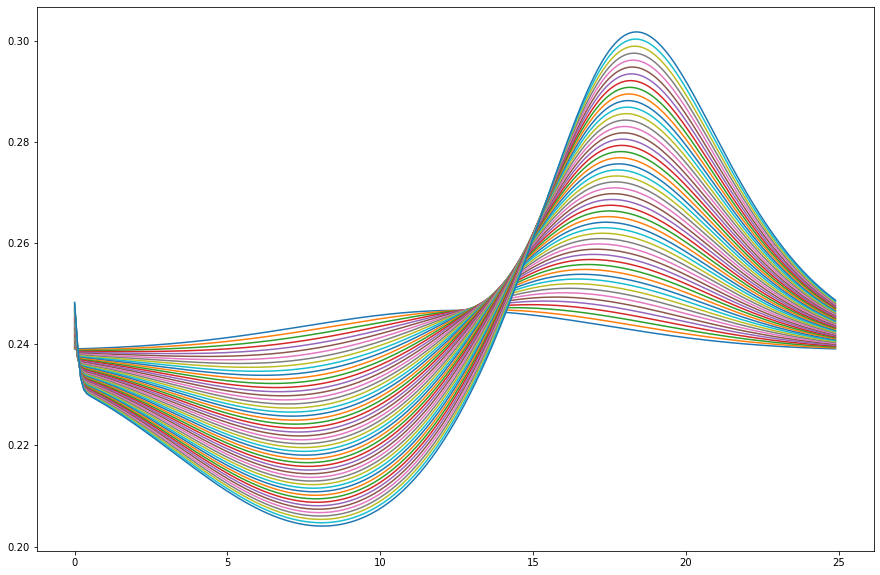

In [14]:
fig = plt.figure(figsize = (15,10))
plt.plot(X,ntot[0,:,:]);

In [11]:
figsize = (10,6)

def plot_reshape(arr):
    return np.swapaxes(arr, 0, 1)

def line_plots(domain, arr, x_name, y_name):
    num_axes = len(arr)
    fig, axes = plt.subplots(nrows = 1, ncols = num_axes, figsize = figsize)
    for corr in range(len(arr)):
        for snapshot in range(len(arr[corr])):
            axes[corr].plot(domain, arr[corr, snapshot], label=f'Time Step {round(snapshot/Tlngth, 2)}')

            # plt.title(f"Axis{VariableNameHere}")
            plt.xlabel(x_name)
            plt.ylabel(y_name)
            # plt.legend()

    return axes

def colormap_plot(space_domain, time_domain, arr, x_name, y_name):
    num_axes = len(arr)
    fig, axes = plt.subplots(nrows = 1, ncols = num_axes, figsize = figsize)
    for corr in range(len(arr)):
        flip_corr = np.flip(arr[corr], axis = 0)
        axes[corr].imshow(flip_corr, extent=[space_domain.min(), space_domain.max(), time_domain.min(), time_domain.max()], aspect='auto', cmap='viridis')

        # plt.title(f"Axis{VariableNameHere}")
        plt.xlabel(x_name)
        plt.ylabel(y_name)
        # plt.legend()

    return axes

ValueError: x and y must have same first dimension, but have shapes (250,) and (51,)

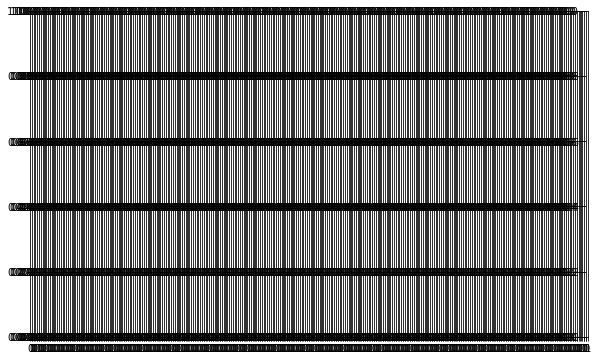

In [12]:
ntot_data = np.swapaxes(ntot, 0, 1)
vtot_data = np.swapaxes(vtot, 0, 1)
etot_data = np.swapaxes(etot, 0, 1)

Xgrid, Snapgrid = np.meshgrid(X, Snap)

n_line_plots = line_plots(X,ntot_data, "Space", "Time")
v_line_plots = line_plots(X,vtot_data, "Space", "Time")
# # efigs = line_plots(etot_data)

n_colormaps = colormap_plot(X, T, ntot_data, "Space", "Time")
v_colormaps = colormap_plot(X, T, vtot_data, "Space", "Time")
# e_colormaps = colormap_plot(X, T, etot_data)

# plt.show()

In [ ]:
# Plot Initial Condition
line_plots(X, ntot_data[:,0][:,np.newaxis,:]-nmean, "Space", "Time")
# line_plots(X, vtot_data[:,0][:,np.newaxis,:], "Space", "Time")
colormap_plot(X, T, ntot_data[:,0:10])
plt.show()

In [ ]:
# Plot Boundary Condition
# midpoint = int(Xnum/2)
# bandwidth = 5

# ntot_data_new = half_domain_shift(ntot_data)
# vtot_data_new = half_domain_shift(vtot_data)
# X_new = half_domain_shift(X)

# line_plots(X[midpoint-bandwidth:midpoint+bandwidth],ntot_data_new[:,:,midpoint-bandwidth:midpoint+bandwidth], "Space", "Time")
# line_plots(X[midpoint-bandwidth:midpoint+bandwidth],vtot_data_new[:,:,midpoint-bandwidth:midpoint+bandwidth], "Space", "Time")

In [ ]:
def fft(arr):
    return np.fft.fftshift(np.fft.fft2(arr))

def fold_average_along_axis(arr, axis=0):
    """
    Fold and average an ndarray along the specified axis.

    Parameters:
        array (numpy.ndarray): Input ndarray.
        axis (int, optional): Axis along which to fold and average (default is 0 for rows).

    Returns:
        numpy.ndarray: Folded and averaged result.
    """
    shape = list(arr.shape)
    shape[axis] = (shape[axis] + 1) // 2  # Calculate the size after folding

    left = arr.take(indices=range(0,shape[axis]), axis=axis)
    fold_left = np.flip(left, axis=axis)
    right = arr.take(indices=range(shape[axis]-1,2*shape[axis]-1), axis=axis)
    folded_avg = (fold_left + right) / 2.0

    return folded_avg

In [ ]:
centered_ntot_data = ntot_data - np.mean(ntot_data)
nfft = np.array([fft(ntot_data_corr) for ntot_data_corr in centered_ntot_data])

T_freq_min = 2*np.pi/Tlngth
T_freq_max = np.pi/dt
X_freq_min = 2*np.pi/Xlngth
X_freq_max = np.pi/dx

# T_freq = np.linspace(T_freq_min, T_freq_max, Tsteps+1, endpoint = True)
# X_freq = np.linspace(X_freq_min, X_freq_max, Xnum, endpoint = True)

T_freq = np.linspace(T_freq_min, T_freq_max, Tsteps+1, endpoint = True)
X_freq = np.linspace(X_freq_min, X_freq_max, Xnum, endpoint = True)

colormap_plot(X_freq,T_freq, np.abs(nfft), "Spatial Frequency (k)", "Dispersion (omega)")

# TODO: Fix Folding Algorithm
folded_nfft = fold_average_along_axis(nfft, axis = 2)
folded_nfft = fold_average_along_axis(folded_nfft, axis = 1)

structure_factor = np.abs(folded_nfft)**2

colormap_plot(X_freq,T_freq, structure_factor, "Spatial Frequency (k)", "Dispersion (omega)")

In [ ]:
# DMD
def dmd_analysis(data, rank):
    dmd = DMD(svd_rank=rank)  # Use svd_rank=-1 to compute all modes
    dmd.fit(data)
    
    return dmd

In [ ]:
ntot_spatial_temporal = np.swapaxes(ntot_data, 1, 2)

for corr in ntot_spatial_temporal:
    dmd_data = dmd_analysis(corr, rank = 10)

    modes = dmd_data.modes
    eigenvalues = dmd_data.eigs
    dynamics = dmd_data.dynamics
    reconstructed_data = dmd_data.reconstructed_data
    
    # Plotting Eigenvalues
    fig_eigenvalues = plt.figure(figsize=(15,10))
    for eig in eigenvalues:
        print(
            "Eigenvalue {}: distance from unit circle {}".format(
                eig, np.abs(np.sqrt(eig.imag**2 + eig.real**2) - 1)
            )
        )
    plot_eigs(dmd_data, show_axes=True, show_unit_circle=True)
    
    # Plot Modes and Dynamics
    fig_modes = plt.figure(figsize=(15,10))
    for mode in dmd_data.modes.T:
        plt.plot(X, mode.real)
        plt.title("Modes")
    plt.show()

    fig_dynamics = plt.figure(figsize=(15,10))
    for dynamic in dmd_data.dynamics:
        plt.plot(Snap, dynamic.real)
        plt.title("Dynamics")
    plt.show()
    
    
    # Plotting Reconstructed Data
    fig_reconstructed_data = plt.figure(figsize=(15, 8))
    for n, mode, dynamic in zip(range(131, 133), dmd_data.modes.T, dmd_data.dynamics):
        plt.subplot(n)
        plt.pcolor(Xgrid, Snapgrid, (mode.reshape(-1, 1).dot(dynamic.reshape(1, -1))).real.T)

    plt.subplot(133)
    plt.pcolor(Xgrid, Snapgrid, dmd_data.reconstructed_data.T.real)
    plt.colorbar()

    plt.show()
    
    # Measure Difference Reconstructed & Original Data
    dmd_diff = (corr.T - dmd_data.reconstructed_data.T).real
    plt.pcolor(Xgrid, Snapgrid, dmd_diff)
    fig = plt.colorbar()
    plt.show()
    
    print("Difference Between DMD Reconstructed Data & Original: ", np.linalg.norm(dmd_diff))

In [ ]:
# Forecasting



In [ ]:
# Var(Number)

In [ ]:
# Kernel DMD - Nonlinear DMD